| **Chapter**                   | 8:  Spatial dynamics of epidemics |
| ----------------------------- |-----------------------------------|
| **Computational Note**        | 8.3: Kernel neighbourhoods        |
| **Package prerequisites**     | None                              |


# Kernel neighbourhoods

In [1]:
import numpy as np
from scipy import stats, ndimage
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import PowerNorm
from matplotlib import rcParams
from math import floor

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay"

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

scipy     : 1.8.1
numpy     : 1.21.6
seaborn   : 0.11.2
matplotlib: 3.5.2



In [3]:
xsize, ysize = 40, 40
max_iterations = 100
gamma = 1/6

In [4]:
beta_matrix = stats.norm(0.7, 0.005).rvs(size=xsize * ysize).reshape(xsize, ysize)

In [5]:
I_0_matrix = stats.norm(1e-2, 1e-4).rvs(size=xsize * ysize).reshape(xsize, ysize)
spot = (floor(xsize/3), floor(ysize/3))
width = floor(xsize/10)

I_0_matrix[spot[0]-width:spot[0]+width, spot[1]-width:spot[1]+width] = stats.norm(5e-2, 1e-3).rvs(size=(2 * width)**2).reshape(2*width, 2*width)
S_0_matrix = np.ones(shape=(xsize, ysize)) - I_0_matrix

In [6]:
population_matrix = stats.norm(1e3, 3e2).rvs(size=xsize * ysize).reshape(xsize, ysize)

N = np.sum(population_matrix)

In [7]:
S_0_matrix *= population_matrix
I_0_matrix *= population_matrix

<AxesSubplot:>

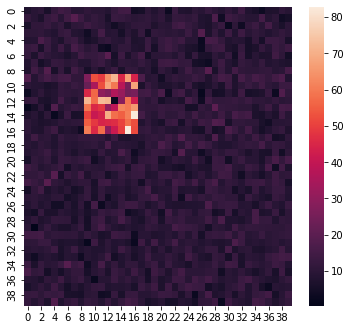

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(6, 5.5))
sns.heatmap(I_0_matrix )

In [9]:
I_arr, S_arr, R_arr = [I_0_matrix], [S_0_matrix], [np.zeros_like(S_0_matrix)]

In [10]:
for i in range(max_iterations):
    kernel = np.array(np.ones(shape=(6, 6)))

    I_prev_neighbourhood = ndimage.convolve(I_arr[-1], weights=kernel, mode="reflect")
    S_prev_neighbourhood = ndimage.convolve(S_arr[-1], weights=kernel, mode="reflect")
    R_prev_neighbourhood = ndimage.convolve(R_arr[-1], weights=kernel, mode="reflect")
    
    N_prev = I_prev_neighbourhood + S_prev_neighbourhood + R_prev_neighbourhood

    S_arr.append(S_arr[-1] - beta_matrix * S_arr[-1]/N_prev * I_prev_neighbourhood)
    I_arr.append(I_arr[-1] + beta_matrix * S_arr[-1]/N_prev * I_prev_neighbourhood - gamma * I_arr[-1])
    R_arr.append(R_arr[-1] + gamma * I_arr[-1])

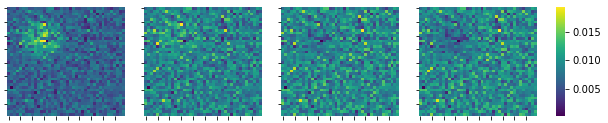

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2), gridspec_kw={"width_ratios": [1,1,1,1,0.08]})


sns.heatmap(I_arr[7]/N_prev, ax=axes[0], cbar=False, cmap=sns.color_palette("viridis", as_cmap=True))
sns.heatmap(I_arr[10]/N_prev, ax=axes[1], cbar=False, cmap=sns.color_palette("viridis", as_cmap=True))
sns.heatmap(I_arr[13]/N_prev, ax=axes[2], cbar=False, cmap=sns.color_palette("viridis", as_cmap=True))
sns.heatmap(I_arr[16]/N_prev, ax=axes[3],  cbar_ax=axes[4], cmap=sns.color_palette("viridis", as_cmap=True))

for a in axes[0:4]:
    a.set(xticklabels=[], yticklabels=[])

plt.savefig("spatial_lattice_interaction_days.pdf")

In [12]:
I_fractions = np.dstack(I_arr)
S_fractions = np.dstack(S_arr)

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_59143/3035896768.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


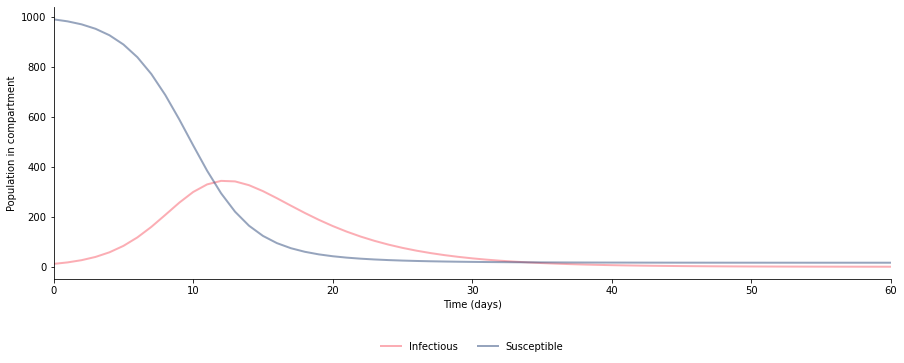

In [13]:
fig = plt.figure(facecolor="w", figsize=(15, 6))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(range(I_fractions.shape[2]), [I_fractions[:, :, i].mean() for i in range(I_fractions.shape[2])], color=COLORS["I"], alpha=0.5, lw=2, label="Infectious")
ax.plot(range(S_fractions.shape[2]), [S_fractions[:, :, i].mean() for i in range(S_fractions.shape[2])], color=COLORS["S"], alpha=0.5, lw=2, label="Susceptible")

ax.set_xlabel('Time (days)')
ax.set_ylabel("Population in compartment")
ax.set_xlim(0, 60)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)

#ax.set_yscale("log")

fig.subplots_adjust(bottom=0.25)
plt.legend(title='', bbox_to_anchor=(0.5, -0.3), loc="lower center", ncol=3, frameon=False)

plt.savefig("sir_from_interacting_lattice.pdf")
plt.show()

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_59143/4162394888.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


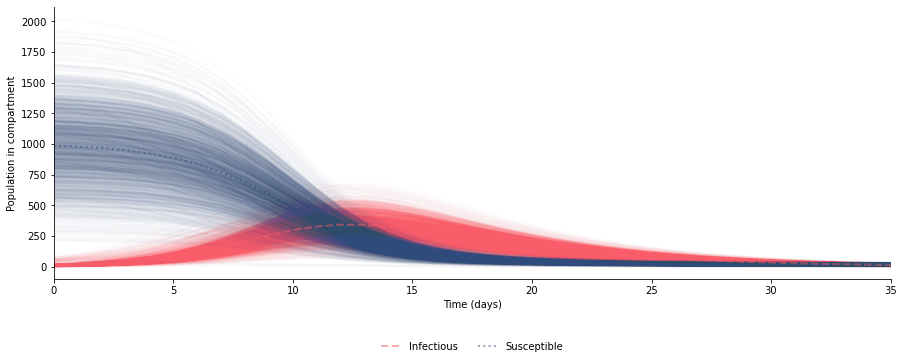

In [14]:
fig = plt.figure(facecolor="w", figsize=(15, 6))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(I_fractions.reshape(xsize * ysize, 101).T, color=COLORS["I"], alpha=0.02, lw=2, label=None)
ax.plot(S_fractions.reshape(xsize * ysize, 101).T, color=COLORS["S"], alpha=0.02, lw=2, label=None)

ax.plot(range(I_fractions.shape[2]), [I_fractions[:, :, i].mean() for i in range(I_fractions.shape[2])], color=COLORS["I"], linestyle="dashed", alpha=0.5, lw=2, label="Infectious")
ax.plot(range(S_fractions.shape[2]), [S_fractions[:, :, i].mean() for i in range(S_fractions.shape[2])], color=COLORS["S"], linestyle="dotted", alpha=0.5, lw=2, label="Susceptible")


ax.set_xlabel('Time (days)')
ax.set_ylabel("Population in compartment")
ax.set_xlim(0, 35)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

legend = ax.legend(["Infectious", "Susceptible"])
legend.get_frame().set_alpha(0.5)

fig.subplots_adjust(bottom=0.25)
plt.legend(title='', bbox_to_anchor=(0.5, -0.3), loc="lower center", ncol=3, frameon=False)

plt.savefig("sir_from_interacting_lattice.pdf")
plt.show()